In [1]:
import tensorflow as tf
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# from tensorflow import keras
# from tf.keras import layers
from sklearn.model_selection import train_test_split

This code will apply various techniques in Machine Learning on the advection-diffusion equation, commonly found in many physics and engineering applications, particularly in fluid dynamics. Let $u(x, t)$ be a space-time dependent quantity, such as temperature or concentration in a fluid flow, its corresponding advection diffusion equation is given by

$$\frac{\partial u}{\partial t} = v \frac{\partial u}{\partial x} + D \frac{\partial^2 u}{\partial x^2},$$

where $D$ is a diffusion coefficient, $v$ is the advection coefficient describing the speed of the flow.

### Good-old numerical solver

In [2]:
x_left = -2
x_right = 2
t_end = 2

D = 0.02
v = 0.1
dx = 0.01
dt = 0.001

cfl = D*dt/dx**2
print('CFL = %.4f'%(cfl))
x_steps = int((x_right - x_left)/dx)
t_steps = int(t_end/dt)

xx = np.linspace(x_left, x_right, x_steps)
tt = np.linspace(0, t_end, t_steps)
uu = np.zeros((t_steps, x_steps))

# ICs
def gaussian(x, mu, sig, shift):
    return shift + np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

ic_mean = 0
ic_std = 0.2
ic_shift = 0 
uu[0, :] = gaussian(xx, ic_mean, ic_std, ic_shift)

CFL = 0.2000


We discretize the equation using central difference: 
$$\frac{\partial u}{\partial x} \approx \frac{u^j_{i+1} - u^j_{i-1} }{2 \Delta x} $$
We write the diffusion equation as
$$ u(x_i, t_{i+1}) = u(x_i, t_i) + D \left(\frac{\Delta t}{\Delta x}\right)^2  (u(x_{i-1}, t_i) - 2 u(x_i, t_i) + u(x_{i+1}, t_i) ) + v \frac{\Delta t}{2\Delta x} (u(x_{i+1}, t_i) - u(x_{i-1}, t_i))$$

In [3]:
# Euler Stepper
def adv_diff_euler_step(ul, uc, ur, D, v, dx, dt):
    return uc + D * dt/dx**2 * (ul - 2 * uc + ur) + v * dt/(2*dx) * (ur - ul)

# Solve
inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)

        # zero flux BC
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Save data
        inputs.append([t, x])
        outputs.append(uu[ti+1, xi])


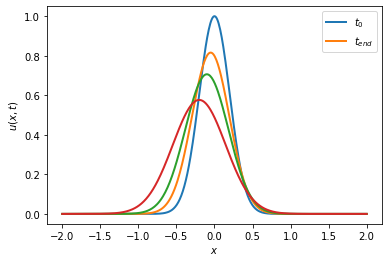

In [4]:
fig = plt.figure()
nn = uu.shape[0]
plt.plot(xx, uu[0, :], lw=2)
plt.plot(xx, uu[nn//4, :], lw=2)
plt.plot(xx, uu[nn//2, :], lw=2)
plt.plot(xx, uu[-1, :], lw=2)
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend(['$t_0$', '$t_{end}$'])


plt.show()

### Approximate the solution by a neural network?
A *naive* first step would be to approximate the function $u(x, t)$ by building a neural network with inputs $(x, t)$ and output $u$. While this is not particularly useful in this context, a neural network approximation can be useful for surrogate modeling, when an approximation of the solver is faster than the direct numerical simulation (DNS).

In [5]:
test_ratio = 0.25
dev_ratio = 0.2
shuffle=False

# Prepare data
inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

# Split into train-dev-test sets
X_train, X_test, y_train, y_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=shuffle)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=dev_ratio, shuffle=shuffle)

In [8]:

# Build model
deep_approx = tf.keras.models.Sequential()
deep_approx.add(tf.keras.layers.Dense(10, input_dim=2, activation='elu'))
deep_approx.add(tf.keras.layers.Dense(10, activation='elu'))
deep_approx.add(tf.keras.layers.Dense(1, activation='linear'))

# Compile model
deep_approx.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_approx.fit(X_train, y_train, 
            epochs=10, batch_size=32, 
            validation_data=(X_dev, y_dev),
            callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/10
14918/14918 [==============================] - 12s 769us/step - loss: 0.0133 - val_loss: 1.6083e-04
Epoch 2/10
14918/14918 [==============================] - 11s 766us/step - loss: 1.0590e-04 - val_loss: 1.1916e-04
Epoch 3/10
14918/14918 [==============================] - 11s 755us/step - loss: 5.3989e-05 - val_loss: 6.9130e-05
Epoch 4/10
14918/14918 [==============================] - 13s 874us/step - loss: 4.3436e-05 - val_loss: 6.5468e-05
Epoch 5/10
14918/14918 [==============================] - 14s 939us/step - loss: 3.7020e-05 - val_loss: 7.5037e-05
Epoch 6/10
14918/14918 [==============================] - 11s 734us/step - loss: 3.2083e-05 - val_loss: 3.8266e-05
Epoch 7/10
14918/14918 [==============================] - 10s 696us/step - loss: 2.9912e-05 - val_loss: 7.4145e-05
Epoch 8/10
14918/14918 [==============================] - 12s 775us/step - loss: 2.6339e-05 - val_loss: 7.4919e-05
Epoch 9/10
14918/14918 [==============================] - 10s 693us/step - loss: 2.4

In [9]:
deep_approx.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


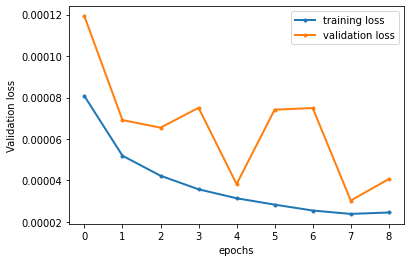

In [10]:
# history.history contains loss information

idx0 = 1
plt.figure()
plt.plot(history.history['loss'][idx0:], '.-', lw=2)
plt.plot(history.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

#### Does it extrapolate in time?

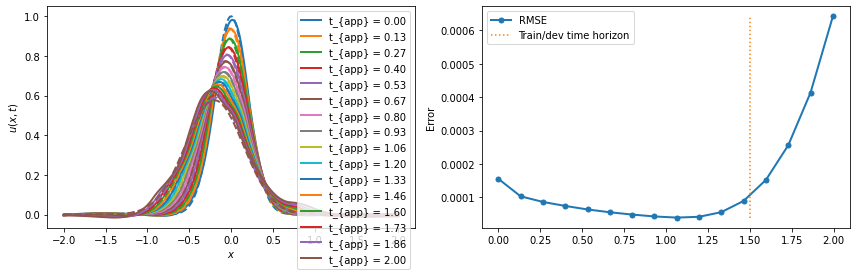

In [15]:
import seaborn as sns
c = sns.color_palette()

nplots = 15
rmin = 0
rmax = 1
idxes = np.arange(int(rmin*len(tt)), int(rmax*len(tt)), int((rmax-rmin)*len(tt)/nplots))
e_mean = []
tt_mean = []

fig = plt.figure(figsize=(12, 4))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for idx, i in enumerate(idxes):
    data_in = np.array([ [tt[i], x] for x in xx])
    u_approx = deep_approx.predict(data_in)
    ax0.plot(xx, u_approx, lw=2, color=c[idx%len(c)], label='t_{app} = %.2f'%(tt[i]))
    ax0.plot(xx, uu[i, :], lw=2, linestyle='--')
    tt_mean.append(tt[i])
    e_mean.append( np.mean((u_approx[:, 0] - uu[i, :])**2) )

ax0.legend()

ax1.plot(tt_mean, e_mean, '.-', lw=2, color=c[0], markersize=10)
ax1.plot([(1-test_ratio)*t_end]*2, [min(e_mean), max(e_mean)], ':', color=c[1])
ax1.legend(['RMSE', 'Train/dev time horizon'])

ax0.set_xlabel('$x$')
ax0.set_ylabel('$u(x, t)$')
# ax0.legend(['$t^*_{end}$'])
ax1.set_ylabel('Error')

fig.tight_layout()
plt.show()

### Approximate the integrator by a recurrence relation (i.e. RNN), mimicking the discretized differential equation
We can basically fit the coefficient of the Euler stepping function we used above `adv_diff_euler_step(ul, uc, ur, D, v, dx, dt)`. If we ignore its dependence on input parameters, we're approximating the function $\phi$ in

$$u(t_i, x_i) = \phi(u(t_{i-1}, x_{i-1}), u(t_{i-1}, x_{i}), u(t_{i-1}, x_{i+1}))$$

In dynamical systems where the state $u$ only depends on time, $\phi$ is commonly referred as a **flow map**, and we look to approximate the function
$$ u(t_i) = \phi(u(t_{i-1})) $$

These paper use this approach:
- https://www.youtube.com/watch?v=Jfl3dIlSTrU 

In [12]:
# Let's run the simulation and save the data at each step

inputs = []
outputs = []
for ti, t in enumerate(tt[:-1]):
    for xi, x in enumerate(xx[1:-1]):
        uu[ti+1, xi] = adv_diff_euler_step(uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1], D, v, dx, dt)
        uu[ti+1, 0] = uu[ti+1, 1]
        uu[ti+1, -1] = uu[ti+1, -2]

        # Collect data
        inputs.append([uu[ti, xi-1], uu[ti, xi], uu[ti, xi+1]])
        outputs.append(uu[ti+1, xi])

inputs_array = np.asarray(inputs)
outputs_array = np.asarray(outputs)

Xs_train, Xs_test, ys_train, ys_test = train_test_split(inputs_array, outputs_array, test_size=test_ratio, shuffle=False)
Xs_train, Xs_dev, ys_train, ys_dev = train_test_split(Xs_train, ys_train, test_size=dev_ratio, shuffle=True)

In [14]:
## linear regression of stepper
from tensorflow import keras

# Build model
deep_stepper = keras.models.Sequential()
deep_stepper.add(tf.keras.layers.Dense(1, input_dim=3, activation='linear', use_bias=False))

# Compile model
deep_stepper.compile(loss='mse', optimizer='Adam')

# Fit!
history = deep_stepper.fit(Xs_train, ys_train, epochs=20, batch_size=32, 
            validation_data=(Xs_dev, ys_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/20
14918/14918 [==============================] - 10s 663us/step - loss: 0.0154 - val_loss: 1.2505e-07
Epoch 2/20
14918/14918 [==============================] - 10s 671us/step - loss: 6.2767e-08 - val_loss: 3.8208e-08
Epoch 3/20
14918/14918 [==============================] - 11s 735us/step - loss: 5.6490e-08 - val_loss: 4.9405e-08
Epoch 4/20
14918/14918 [==============================] - 9s 592us/step - loss: 5.5799e-08 - val_loss: 3.8800e-08
Epoch 5/20
14918/14918 [==============================] - 9s 596us/step - loss: 5.5681e-08 - val_loss: 1.1844e-07
Epoch 6/20
14918/14918 [==============================] - 9s 634us/step - loss: 5.6656e-08 - val_loss: 5.3448e-08
Epoch 7/20
14918/14918 [==============================] - 9s 619us/step - loss: 5.2292e-08 - val_loss: 4.8370e-08


In [ ]:
from sklearn.linear_model import LinearRegression

L = LinearRegression(fit_intercept=False)
L.fit(Xs_train, ys_train)
L.score(Xs_dev, ys_dev)
print(L.coef_)
print(deep_stepper.get_weights()[0])

[0.195 0.6   0.205]
[[-0.1200459 ]
 [ 0.8355905 ]
 [ 0.28442588]]


In [ ]:
## Integrate with the neural network
# WARNING (and lesson): this will take too long! (around 10 minutes)

# uu_deep = np.zeros(uu.shape)
# uu_deep[0, :] = uu[0, :]

# for ti in tqdm(range(len(tt[:-1]))):
#     for xi, x in enumerate(xx[1:-1]):
#         input_stencil = np.array([[uu_deep[ti, xi-1], uu_deep[ti, xi], uu_deep[ti, xi+1]]])
#         uu_deep[ti+1, xi] = deep_stepper( input_stencil )[0][0].numpy()
#     uu_deep[ti+1, 0] = uu_deep[ti+1, 1]
#     uu_deep[ti+1, -1] = uu_deep[ti+1, -2]

In [ ]:
# Can accelerate by vectorizing input_stencil

uu_deep = np.zeros(uu.shape)
uu_deep[0, :] = uu[0, :]

for ti in tqdm(range(len(tt[:-1]))):
    input_stencil = np.vstack([uu_deep[ti, :-2], uu_deep[ti, 1:-1], uu_deep[ti, 2:]]).T
    uu_deep[ti+1, 1:-1] = deep_stepper( input_stencil ).numpy().flatten()
    uu_deep[ti+1, 0] = uu_deep[ti+1, 1]
    uu_deep[ti+1, -1] = uu_deep[ti+1, -2]


uu_lin = np.zeros(uu.shape)
uu_lin[0, :] = uu[0, :]

for ti in tqdm(range(len(tt[:-1]))):
    input_stencil = np.vstack([uu_lin[ti, :-2], uu_lin[ti, 1:-1], uu_lin[ti, 2:]]).T
    uu_lin[ti+1, 1:-1] = L.predict( input_stencil ).flatten()
    uu_lin[ti+1, 0] = uu_lin[ti+1, 1]
    uu_lin[ti+1, -1] = uu_lin[ti+1, -2]

100%|██████████| 1999/1999 [00:00<00:00, 12422.84it/s]


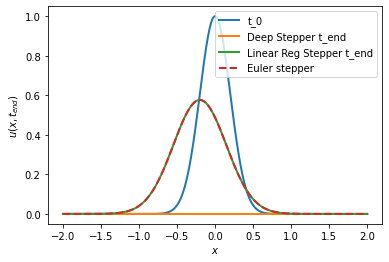

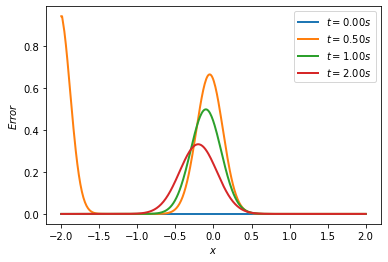

In [ ]:
fig = plt.figure()
n = -1
plt.plot(xx, uu[0, :], lw=2, label='t_0')
plt.plot(xx, uu_deep[n, :], lw=2, label='Deep Stepper t_end')
plt.plot(xx, uu_lin[n, :], lw=2, label='Linear Reg Stepper t_end')
plt.plot(xx, uu[n, :], '--', lw=2, label='Euler stepper')
plt.xlabel('$x$')
plt.ylabel('$u(x, t_{end})$')
plt.legend()

idx_list = [0, int(len(tt)/4), int(len(tt)/2), int(len(tt))-1]
leg = []
fig = plt.figure()
for idx in idx_list:
    plt.plot(xx, (uu_deep[idx, :] - uu[idx, :])**2, lw=2)
    leg.append('$t=%.2f s$'%(tt[idx]))
plt.xlabel('$x$')
plt.ylabel('$Error$')
plt.legend(leg)

plt.show()

The Euler step: 
$$ u(t_{i+1}, x_i) \leftarrow u(t_i, x_i) + D dt/dx^2  (u(t_i, x_{i-1}) - 2 u(t_i, x_i) + u(t_i, x_{i+1})) + v dt/(2dx) (u(t_i, x_{i+1}) - u(t_i, x_{i-1})) $$

In [ ]:
# If the time stepper is linear. Does it learn the right coefficients?

# Euler step: uc + D * dt/dx**2 * (ul - 2 * uc + ur) + v * dt/(2*dx) * (ur - ul)

weights = deep_stepper.get_weights()[0]

if len(deep_stepper.get_weights())>1:
    bias = deep_stepper.get_weights()[1]
    print('bias = ', bias)

drift = v*dt/(2*dx)
diff = D*dt/dx**2
print("actual coefficient of u_left is %.5f and the fit is %.5f"%(diff - drift, weights[0]))
print("actual coefficient of u_center is %.5f and the fit is %.5f"%(-2*diff + 1, weights[1]) )
print("actual coefficient of u_right is %.5f and the fit is %.5f"%(diff + drift, weights[2]))

## 

actual coefficient of u_left is 0.19500 and the fit is 0.14331
actual coefficient of u_center is 0.60000 and the fit is 0.70318
actual coefficient of u_right is 0.20500 and the fit is 0.15342


In [ ]:
diffa = ((weights[0]+weights[2])/2)[0]
drifta = ((weights[2]-weights[0])/2)[0]
print('drift: ', drift, drifta)
print('diffusion: ', diff, diffa)

s= uu.shape[1]//2
uc = uu[-7, s]
ul = uu[-7, s-1]
ur = uu[-7, s+1]

unew_true = (1-2*diff)*uc + (diff+drift)*ul + (diff-drift)*ur
unew_ml = (1-2*diffa)*uc + (diffa+drifta)*ul + (diffa-drifta)*ur 
print((1-2*diff)*uc, (diff+drift)*ul, (diff-drift)*ur, '=', unew_true )
print((1-2*diffa)*uc, (diffa+drift)*ul, (diffa-drift)*ur, '=', unew_ml)

drift:  0.005 0.0052528977
diffusion:  0.2 0.42266086
0.2907719349016479 0.10101787064375495 0.09286014195045775 = 0.48464994749586054
0.07496017375361465 0.21073848378621649 0.1988925461996885 = 0.48459539279952013


### In general, you're not guaranteed to get the same solution, why?

In [ ]:
deep_stepper.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Nonlinear regression of stepper

# Build model
inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(10, activation='elu')(inputs)
x = tf.keras.layers.Dense(10, activation='elu')(x)
x = tf.keras.layers.Dense(10, activation='elu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

deep_stepper2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='non_linear_integrator')

# Compile model
deep_stepper2.compile(loss='mse', optimizer='adam')

# Fit!
history = deep_stepper2.fit(Xs_train, ys_train, epochs=25, batch_size=32, 
            validation_data=(Xs_dev, ys_dev),
            callbacks=keras.callbacks.EarlyStopping(patience=5))

Epoch 1/25
14918/14918 [==============================] - 13s 879us/step - loss: 1.4638e-04 - val_loss: 4.4982e-07
Epoch 2/25
14918/14918 [==============================] - 14s 915us/step - loss: 1.2325e-06 - val_loss: 6.3472e-08
Epoch 3/25
14918/14918 [==============================] - 13s 889us/step - loss: 8.9691e-07 - val_loss: 4.2952e-08
Epoch 4/25
14918/14918 [==============================] - 13s 867us/step - loss: 4.5540e-07 - val_loss: 5.0746e-08
Epoch 5/25
14918/14918 [==============================] - 12s 809us/step - loss: 4.9809e-07 - val_loss: 1.1563e-07
Epoch 6/25
14918/14918 [==============================] - 13s 877us/step - loss: 4.7937e-07 - val_loss: 5.8257e-08
Epoch 7/25
14918/14918 [==============================] - 14s 950us/step - loss: 3.4100e-07 - val_loss: 4.9963e-08
Epoch 8/25
14918/14918 [==============================] - 13s 874us/step - loss: 2.3890e-07 - val_loss: 1.0991e-08
Epoch 9/25
14918/14918 [==============================] - 14s 917us/step - loss:

In [ ]:
## Integrate with the neural network
# WARNING (and lesson): this will take too long! (around 10 minutes)
# Can accelerate by vectorizing input_stencil

uu_deep2 = np.zeros(uu.shape)
uu_deep2[0, :] = uu[0, :]

for ti, t in enumerate(tt[:-1]):
    # print(ti/len(tt))
    input_stencil = np.vstack([uu_deep2[ti, :-2], uu_deep2[ti, 1:-1], uu_deep2[ti, 2:]]).T
    uu_deep2[ti+1, 1:-1] = deep_stepper( input_stencil ).numpy().flatten()
    uu_deep2[ti+1, 0] = uu_deep2[ti+1, 1]
    uu_deep2[ti+1, -1] = uu_deep2[ti+1, -2]

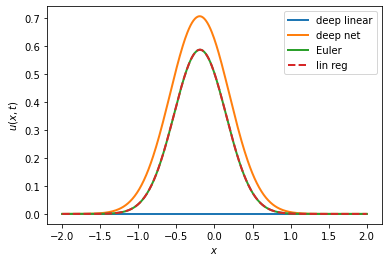

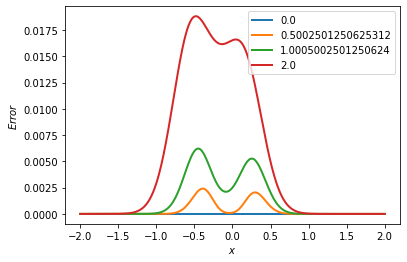

In [ ]:
fig = plt.figure()
plt.plot(xx, uu_deep[-100, :], lw=2, label='deep linear')
plt.plot(xx, uu_deep2[-100, :], lw=2, label='deep net')
plt.plot(xx, uu[-100, :], lw=2, label='Euler')
plt.plot(xx, uu_lin[-100, :], '--', lw=2, label='lin reg')
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.legend()

idx_list = [0, int(len(tt)/4), int(len(tt)/2), int(len(tt))-1]
leg = []
fig = plt.figure()
for idx in idx_list:
    plt.plot(xx, (uu_deep2[idx, :] - uu[idx, :])**2, lw=2)
    leg.append(str(tt[idx]))
plt.xlabel('$x$')
plt.ylabel('$Error$')
plt.legend(leg)


#### Generalize over $D$, $v$, $dx$, $dt$?